# 1. Prepare

## 1.1. Settings

In [2]:
from keras import optimizers
from keras.applications.mobilenet import MobileNet
from keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.layers import Activation, Conv2D, Dense, Dropout, GlobalAveragePooling2D, Reshape
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot

import itertools
from IPython.display import SVG
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import time

%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


In [30]:
alpha = 1
input_size = 224

batch_size = 16
batch_size_val = 16

epochs_phase_1 = 10
epochs_phase_2 = 40
epochs_phase_3 = 40

cpu_threads = 8

## 1.2. Data and augmentaion

In [38]:
train_directory = './data/train'
validation_directory = './data/validation'
test_directory = './data/test'

In [39]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=.1,
    height_shift_range=.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='reflect')

validgen = ImageDataGenerator(rescale=1./255)

testgen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_directory,
    target_size=(input_size, input_size),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True)

validation_generator = validgen.flow_from_directory(
    validation_directory,
    target_size=(input_size, input_size),
    class_mode='categorical',
    batch_size=batch_size_val,
    shuffle=True)

test_generator = testgen.flow_from_directory(
    test_directory,
    target_size=(input_size, input_size),
    batch_size=1,
    class_mode='categorical',
    shuffle=False)

train_samples = train_generator.samples
validation_samples = validation_generator.samples
test_samples = test_generator.samples

num_classes = train_generator.num_class

Found 24561 images belonging to 7 classes.
Found 11074 images belonging to 7 classes.
Found 1289 images belonging to 7 classes.


## 1.3. Model

In [6]:
base_model = MobileNet(
    weights='imagenet',
    include_top=False,
    input_shape=(input_size, input_size, 3),
    alpha=alpha)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Reshape((1, 1, int(1024 * alpha)))(x)
x = Dropout(1e-3)(x)
x = Conv2D(num_classes, (1, 1), padding='same')(x)
x = Activation('softmax')(x)
predictions = Reshape((num_classes,))(x)

model = Model(inputs=base_model.input, outputs=predictions)

Model graph:

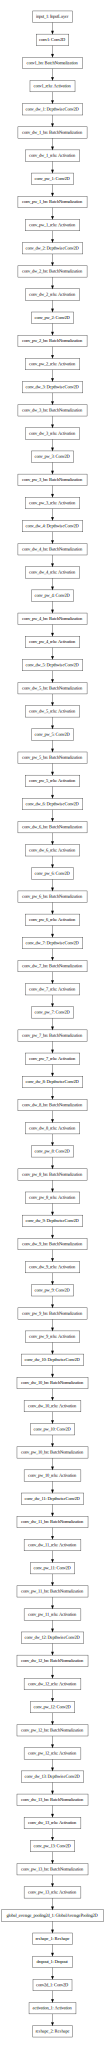

In [8]:
plot_model(model, to_file='mobilenet.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

# 2. Train

## 2.1. Phase 1
Train only the top layers (which were randomly initialized).

In [6]:
for layer in base_model.layers:
    layer.trainable = False

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.RMSprop(lr=1e-3, decay=0.00004),
    metrics=['accuracy'])

checkpointer = ModelCheckpoint(
    filepath='./output/checkpoints/mobilenet_phase_1.h5',
    save_weights_only=True,
    save_best_only=True)

csv_logger = CSVLogger('./output/logs/mobilenet_phase_1.csv', separator=';')

early_stopper = EarlyStopping(
    monitor='val_acc',
    min_delta=0.05,
    patience=2,
    verbose=1)

tensorboard = TensorBoard(
    log_dir='./output/logs/mobilenet_phase_1',
    write_graph=True)

model.fit_generator(
    train_generator,
    steps_per_epoch=train_samples // batch_size,
    epochs=epochs_phase_1,
    validation_data=validation_generator,
    validation_steps=validation_samples // batch_size_val,
    verbose=1,
    callbacks=[csv_logger, checkpointer, early_stopper, tensorboard],
    workers=cpu_threads)

Epoch 1/10
1535/1535 [==============================] - 224s - loss: 0.5082 - acc: 0.8227 - val_loss: 0.2674 - val_acc: 0.9022
Epoch 2/10
1535/1535 [==============================] - 118s - loss: 0.3514 - acc: 0.8746 - val_loss: 0.2493 - val_acc: 0.9164
Epoch 3/10
1535/1535 [==============================] - 118s - loss: 0.3217 - acc: 0.8881 - val_loss: 0.2423 - val_acc: 0.9151
Epoch 4/10
1535/1535 [==============================] - 117s - loss: 0.3068 - acc: 0.8912 - val_loss: 0.2151 - val_acc: 0.9234
Epoch 00003: early stopping


Load best epoch:

In [25]:
model.load_weights('./output/checkpoints/mobilenet_phase_1.h5')

## 2.2. Phase 2
Train all layers.

In [9]:
for layer in model.layers:
    layer.trainable = True

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.SGD(lr=1e-4, momentum=0.9, nesterov=True, decay=0.00004),
    metrics=['accuracy'])

checkpointer = ModelCheckpoint(
    filepath='./output/checkpoints/mobilenet_phase_2.h5',
    save_weights_only=True,
    save_best_only=True)

csv_logger = CSVLogger('./output/logs/mobilenet_phase_2.csv', separator=';')

early_stopper = EarlyStopping(
    monitor='val_acc',
    min_delta=0.005,
    patience=10,
    verbose=1)

lr_reduce = ReduceLROnPlateau(verbose=1)

tensorboard = TensorBoard(
    log_dir='./output/logs/mobilenet_phase_2',
    write_graph=True)

model.fit_generator(
    train_generator,
    steps_per_epoch=train_samples // batch_size,
    epochs=epochs_phase_2,
    validation_data=validation_generator,
    validation_steps=validation_samples // batch_size_val,
    verbose=1,
    callbacks=[checkpointer, csv_logger, lr_reduce, early_stopper, tensorboard],
    workers=cpu_threads)

Epoch 1/40
1535/1535 [==============================] - 323s - loss: 0.2258 - acc: 0.9206 - val_loss: 0.1224 - val_acc: 0.9608
Epoch 2/40
1535/1535 [==============================] - 324s - loss: 0.1664 - acc: 0.9424 - val_loss: 0.0964 - val_acc: 0.9688
Epoch 3/40
1535/1535 [==============================] - 323s - loss: 0.1480 - acc: 0.9486 - val_loss: 0.1000 - val_acc: 0.9656
Epoch 4/40
1535/1535 [==============================] - 323s - loss: 0.1337 - acc: 0.9549 - val_loss: 0.0833 - val_acc: 0.9731
Epoch 5/40
1535/1535 [==============================] - 324s - loss: 0.1176 - acc: 0.9591 - val_loss: 0.0737 - val_acc: 0.9767
Epoch 6/40
1535/1535 [==============================] - 323s - loss: 0.1043 - acc: 0.9632 - val_loss: 0.0763 - val_acc: 0.9738
Epoch 7/40
1535/1535 [==============================] - 322s - loss: 0.1053 - acc: 0.9636 - val_loss: 0.0707 - val_acc: 0.9756
Epoch 8/40
1535/1535 [==============================] - 322s - loss: 0.1021 - acc: 0.9647 - val_loss: 0.0663 - 

Load best epoch:

In [20]:
model.load_weights('./output/checkpoints/mobilenet_phase_2.h5')

## 2.3. Phase 3

In [14]:
for layer in model.layers:
    layer.trainable = True

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.SGD(lr=1e-5, momentum=0.9, nesterov=True, decay=0.00004),
    metrics=['accuracy'])

checkpointer = ModelCheckpoint(
    filepath='./output/checkpoints/mobilenet_phase_3.h5',
    save_weights_only=True,
    save_best_only=True)

csv_logger = CSVLogger('./output/logs/mobilenet_phase_3.csv', separator=';')

early_stopper = EarlyStopping(
    monitor='val_acc',
    min_delta=0.005,
    patience=10,
    verbose=1)

lr_reduce = ReduceLROnPlateau(
    factor=0.16,
    patience=5,
    verbose=1)

tensorboard = TensorBoard(
    log_dir='./output/logs/mobilenet_phase_3',
    write_graph=True)

model.fit_generator(
    train_generator,
    steps_per_epoch=train_samples // batch_size,
    epochs=epochs_phase_3,
    validation_data=validation_generator,
    validation_steps=validation_samples // batch_size_val,
    verbose=1,
    callbacks=[checkpointer, csv_logger, lr_reduce, early_stopper, tensorboard],
    workers=cpu_threads)

Epoch 1/40
1535/1535 [==============================] - 322s - loss: 0.0713 - acc: 0.9761 - val_loss: 0.0543 - val_acc: 0.9812
Epoch 2/40
1535/1535 [==============================] - 322s - loss: 0.0662 - acc: 0.9780 - val_loss: 0.0523 - val_acc: 0.9810
Epoch 3/40
1535/1535 [==============================] - 322s - loss: 0.0632 - acc: 0.9780 - val_loss: 0.0489 - val_acc: 0.9833
Epoch 4/40
1535/1535 [==============================] - 322s - loss: 0.0681 - acc: 0.9764 - val_loss: 0.0539 - val_acc: 0.9806
Epoch 5/40
1535/1535 [==============================] - 322s - loss: 0.0640 - acc: 0.9778 - val_loss: 0.0531 - val_acc: 0.9817
Epoch 6/40
1535/1535 [==============================] - 322s - loss: 0.0661 - acc: 0.9774 - val_loss: 0.0522 - val_acc: 0.9816
Epoch 7/40
1535/1535 [==============================] - 321s - loss: 0.0673 - acc: 0.9791 - val_loss: 0.0506 - val_acc: 0.9822
Epoch 8/40
1535/1535 [==============================] - 322s - loss: 0.0641 - acc: 0.9779 - val_loss: 0.0520 - 

Load best epoch:

In [33]:
model.load_weights('./output/checkpoints/mobilenet_phase_3.h5')

# 3. Evaluate

## 3.1. Evaluate

In [34]:
score = model.evaluate_generator(test_generator, test_samples)

print('Test accuracy: {:.4f}'.format(score[1]))

Test accuracy: 0.9760


## 3.2. Propagation time

In [40]:
t0 = time.time()
prediction = model.predict_generator(test_generator, test_samples)
pred_time = time.time() - t0

print('Propagation time of {} images: {:.3f} ms ({:.3f} ms per image)'.format(test_samples, pred_time * 1000.0, pred_time / test_samples * 1000.0))

Propagation time of 1289 images: 8799.402 ms (6.827 ms per image)


## 3.3. Confusion matrix

In [41]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

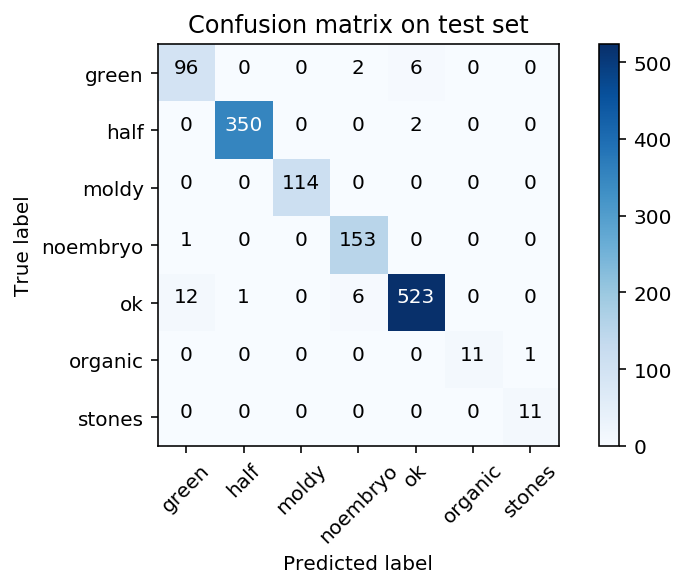

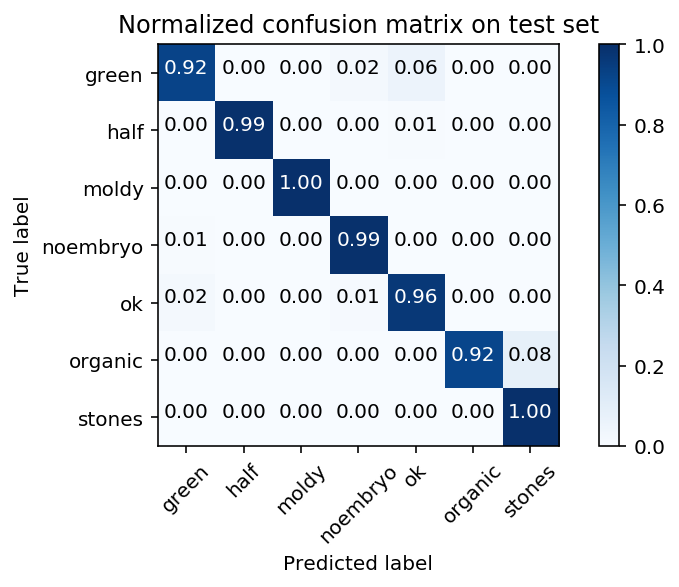

In [42]:
class_names = [key for (key, value) in sorted(test_generator.class_indices.items())]

test_pred = []
for i in prediction:
    test_pred.append(np.argmax(i))

test_cnf_matrix = confusion_matrix(test_generator.classes, test_pred)

np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(test_cnf_matrix, classes=class_names,
                      title='Confusion matrix on test set')
plt.figure()
plot_confusion_matrix(test_cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix on test set')
plt.show()